# 1. Set the path for the files

In [1]:
# library
import os

# import os
path = os.getcwd()

# path with biomass file
path_cell = path+"/00_database/01_input/cells.csv"

# path with toxins file
path_toxin = path+"/00_database/01_input/toxins.csv"

# path out for saving the processed ts
path_out = path+"/00_database/02_preprocessed/table.csv"

# path for saving the fig
path_out_fig = path+"/01_Figures/Dsppxtoxin.png"

# 2. Set the input for processing the data
a) The species and toxin to process.

b) The size in days of the moving windows maximum filter.

c) The knot spacing for the B-spiline smooth function.

d) The interval of years to be processed. Notice that 2020 is used in the smoothing but it is further dicarded in the remaining analysis. This is done for avoiding border effect in the last year and because SST and wind data is not available in 2020.

In [2]:
# species and toxin name in the files columns
specs = ['D. acuminata','D. acuta', 'D. norvegica'] 
toxin = "DSP"

# window filter size
filter_w = 60

# knot spacing
res_b = 60 # in days por bspiline

# years intervall to smooth
year_0 = 2006
year_n = 2020

# months corresponding to summer and autumn when the R² should be computed
month_min = 6
month_max = 11

# minimum of toxin to correlate. This threshold is used because there are a lot of zeros in the data, which is not important for the assessment.
toxin_min_th = 20

# minimum values to detect the peak of blooms
peak_th = 10

# years that are lacking in the raw time series
years_drop = [2011]

# 3. Pre-process and smooth Dinophysis spp. data

In [3]:
# library
import skfda.representation.basis as basis
import skfda.representation.grid as grid
import pandas as pd
import datetime as dt
import numpy as np

# data frame used only to convert data index to julian days
ref_date = pd.DataFrame(index=[dt.date(year_0, 1, 1), dt.date(year_n+1, 1, 1)])
ref_date.index = pd.to_datetime(ref_date.index)
ref_date = ref_date.resample(str(res_b)+"d").first()
ref_date = ref_date[~ref_date.index.year.isin(years_drop)]

# input for the B-spline function
t_1 = int(ref_date.index.to_julian_date()[0])
t_n = int(ref_date.index.to_julian_date()[-1])
valid_range = ref_date.index.to_julian_date().astype(int).values
valid_range.sort()

# start iteraction among the species to smooth
for spec in specs:    
    
    # read cells file
    df_cell = pd.read_csv(path_cell, index_col=0)[[spec]]
    df_cell.index = pd.to_datetime(df_cell.index)
        
    # convert to log scale and filter the interval date
    df_cell = np.log(df_cell+1)
    df_cell = df_cell[(df_cell.index.year>=year_0) & (df_cell.index.year<=year_n)]
    df_cell = df_cell.resample("d").first()
    
    # use the maximum filter data
    df_cell_maxrol = df_cell.rolling(window=filter_w,
                                     center=True,
                                     min_periods=1).max().resample("1d").first()
    
    # interpolate days without values
    subset_tofit = df_cell_maxrol.interpolate()
    
    # remove 2011 from the fit of the B-spline (there is no 2011 data in the original file)
    subset_tofit = subset_tofit[~subset_tofit.index.year.isin(years_drop)]
        
    # config the B-spline
    bss = basis.BSpline(domain_range=(t_1, t_n),
                        knots=list(valid_range),
                        order=4)
    
    # define the function grid
    fgrid = grid.FDataGrid(subset_tofit.dropna().values.ravel(),
                           subset_tofit.dropna().index.to_julian_date()).to_basis(bss)
    
    # smooth the time series
    df_smooth_cell = pd.DataFrame(fgrid.evaluate(df_cell.index.to_julian_date()).ravel(),
                                  index=df_cell_maxrol.index)
        
    df_smooth_cell.columns = [spec]
    df_smooth_cell[df_smooth_cell.index.year.isin(years_drop)] = np.nan
    df_smooth_cell.columns = ["Smoothed " + spec]
    
    if spec == specs[0]:
        df_spec = df_cell.join(df_smooth_cell)
        
    else:
        df_spec = df_spec.join(df_cell.join(df_smooth_cell))
        

/home/edsilv/anaconda3/envs/hab/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# 4. Read toxin data

In [4]:
df_toxin = pd.read_csv(path_toxin, index_col=0)[[toxin]]
df_toxin.index = pd.to_datetime(df_toxin.index)
df_toxin = df_toxin[(df_toxin.index.year>=year_0) & (df_toxin.index.year<=year_n)]
df_toxin = df_toxin.resample("d").first()

# 5. Concatenate all data to the same data frame used for plotting

In [5]:
# convert the D. spp. data to the Cells/L scale
df_spec = np.exp(df_spec)-1

# drop toxin values below the choosen threshold
df_toxin = df_toxin[df_toxin >toxin_min_th]

# concatenate
df = df_spec.join(df_toxin)

# 6. Compute the coefficient of determination (R²) between the Dinophysis spp. and the toxin DSP (same as DST)

In [6]:
# library
from statsmodels.formula.api import ols

# dictionary for saving the R²
r2_dict = {}

# interaction to relate D. spp. and DSP before and after 2011
for time, year_min, year_max in zip(["Before", "After"], [year_0, 2012], [2011, year_n-1]):
    # create the subset for correlating data
    subset_corr = df
    subset_corr = subset_corr[subset_corr.index.year>=year_min]
    subset_corr = subset_corr[subset_corr.index.year<=year_max]
    subset_corr = subset_corr[subset_corr.index.month>=month_min]
    subset_corr = subset_corr[subset_corr.index.month<=month_max]
    
    # test different lags
    for shift in np.arange(-90, 90, 1):
        # subset the lag
        subset_corr_shift = subset_corr.shift(shift)[df.columns[0:-1]].join(subset_corr["DSP"]).dropna()
        n = len(subset_corr_shift)
        
        # inspect if the number of values to relate is at least higher than 10
        if n<=10:
            continue
        
        # scale both the dependent and independent to log scale (outlier issue)
        y = np.log(subset_corr_shift[toxin])
        x = np.log(subset_corr_shift.iloc[:, 0:-1]+1)
        x.columns = [x.replace(" ", "").replace(".", "") for x in x.columns]
        xy = x.join(y)
        
        # iteraction to model DSP for each D. spp.
        for xi in xy.columns[0:-1]:
            # fit model
            model = ols("DSP ~ "+xi, xy).fit()
            
            # retrieve statistics and saves in the dictionary
            smoothed_r = np.round(model.rsquared, 2)
            smoothed_pvalue = np.round(model.pvalues, 2).values[1]
            correct_name = xi.replace("Smoothed", "Smoothed ").replace("Dacuminata", "D. acuminata").replace("Dacuta", "D. acuta").replace("Dnorvegica", "D. norvegica")
            r2_dict[time, shift, correct_name] = [smoothed_r, smoothed_pvalue, n, shift]

# convert dictionary results to a pandas dataframe
df_corr = pd.DataFrame(r2_dict.values(), index=r2_dict.keys())
df_corr.columns = ["R2", "pvalue", "n", "lag"]


# 7. Plot the D. spp. time series, the toxins, and the R².

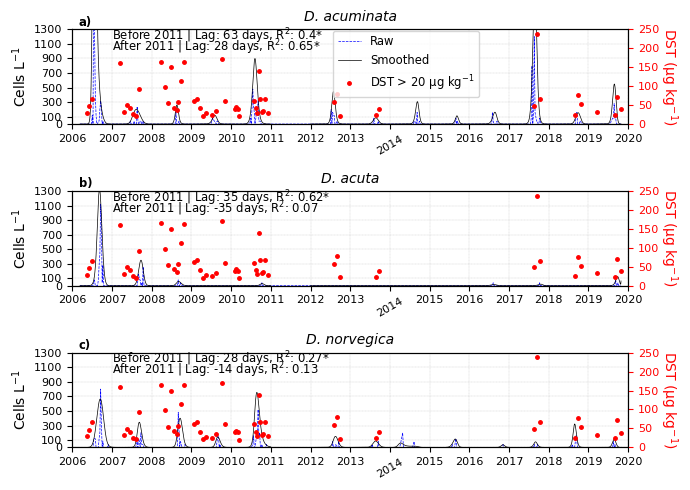

In [7]:
import matplotlib.pyplot as plt
import string

fig = plt.figure(figsize=(7,5))
i = 1

# iteract among the D. spp.
for spec in specs:
    
    # select the highest statistical values and the lag before of 2011
    idxmax_before = df_corr.loc["Before",:,"Smoothed "+spec,:].idxmax()["R2"]
    R_before = df_corr.loc[idxmax_before,"R2"]
    pvalue_before = df_corr.loc[idxmax_before,"pvalue"]
    lag_before = df_corr.loc[idxmax_before,"lag"]
    if pvalue_before<0.05:
        smooth_sign_before = "*"
        
    else:
        smooth_sign_before = ""
    
    # select the highest statistica results and the lag after 2011
    idxmax_after = df_corr.loc["After",:,"Smoothed "+spec,:].idxmax()["R2"]
    R_after = df_corr.loc[idxmax_after,"R2"]
    pvalue_after = df_corr.loc[idxmax_after,"pvalue"]
    lag_after = df_corr.loc[idxmax_after,"lag"]
    if pvalue_after<0.05:
        smooth_sign_after = "*"
        
    else:
        smooth_sign_after = ""
    
    # start the plot
    ax = plt.subplot(3, 1, i)
    
    # plot raw D. spp. data
    im1 = df[spec].dropna().plot(ax=ax,
                       color="blue",
                       alpha=1,
                       linestyle="--",
                       linewidth=0.5,
                       legend=False)
    
    # plot smoothed D. spp.
    im2 = df["Smoothed "+spec].plot(ax=ax,
                       color="k",
                       linewidth=0.5,
                       legend=False)
    
    
    # plot the toxin
    im3 = df[toxin].plot(ax=ax,
                            marker=".",
                            color="r",
                            markersize=5,
                            linestyle="",
                            secondary_y=True)
    
    # add text with statistics and subplot label
    ax.text("2007-01-01", 1150, "Before 2011 | Lag: "+str(lag_before)+" days, R$^2$: "+str(R_before)+smooth_sign_before, fontsize="small")
    ax.text("2007-01-01", 1000, "After 2011 | Lag: "+str(lag_after)+" days, R$^2$: "+str(R_after)+smooth_sign_after, fontsize="small")
    ax.text("2006-03-01", 1350, string.ascii_lowercase[i-1]+")", fontsize="small", fontweight='bold')
    
    # set the tick limits and labels
    ax.set_xlim(("2006-01-01", "2020-01-01"))
    im1.set_ylim((0, 1300))
    im1.set_yticks([0, 100, 300, 500, 700, 900, 1100, 1300])
    im1.set_xticks(["2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013",
                    "2014", "2015", "2016", "2017", "2018", "2019", "2020"])
    im1.set_xticklabels(["2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013",
                         "2014", "2015", "2016", "2017", "2018", "2019", "2020"],
                        ha='center', fontsize=8)
    im3.set_ylim((0, 250))
    im3.set_yticks([0, 50, 100, 150, 200, 250])
    im3.tick_params(axis="x", bottom=True)
    im3.tick_params(axis="y", labelsize=8, colors="red")
    ax.tick_params(axis="y", labelsize=8)
    ax.set_xlabel("")
    im1.set_ylabel("Cells L$^{-1}$")
    im3.set_ylabel("DST (µg kg$^{-1}$)",
                   color="r",
                   rotation=270,
                   labelpad=15)
    
    # add grid
    ax.grid(linewidth=0.2, linestyle="--")
    
    # add title to subplot
    ax.set_title(spec, fontsize="medium", style="italic")
    
    i = i+1
        
fig.legend(["Raw","Smoothed", "DST > 20 µg kg$^{-1}$"],
         bbox_to_anchor=(0.7, 0.94),
          fontsize="small")

plt.tight_layout()
fig.savefig(path_out_fig, dpi=300)

# 8. Show the date and values of all blooms peaks

In [8]:
# library
import scipy.signal as signal

# estimate peaks
df_peaks = df.apply(lambda x: signal.find_peaks(x, height=peak_th))[["Smoothed " +x for x in specs]]

# create a table with the peak and dates
blooms_dict = {}
for spec in specs:
    blooms_dates = df.index[df_peaks["Smoothed "+spec][0]]
    blooms_values = np.round(df_peaks.loc[1,"Smoothed "+spec]["peak_heights"], 0)
    df_bloom = pd.DataFrame([blooms_dates,blooms_values], index=["Date", "Cells/L"]).T
    blooms_dict[spec] = df_bloom

In [9]:
for spec in blooms_dict.keys():
    print(spec)
    print(blooms_dict[spec])
    print()

D. acuminata
         Date Cells/L
0  2006-07-22  3954.0
1  2007-08-12   201.0
2  2008-08-20   261.0
3  2009-08-04   119.0
4  2010-08-08   899.0
5  2012-07-30   447.0
6  2013-08-24    85.0
7  2014-09-11   307.0
8  2015-09-09   113.0
9  2016-08-24   163.0
10 2017-08-27  1868.0
11 2018-09-28   155.0
12 2019-08-28   549.0

D. acuta
        Date Cells/L
0 2006-09-08  1325.0
1 2007-09-24   350.0
2 2008-09-04    59.0
3 2010-10-11    31.0
4 2016-08-14    16.0
5 2017-10-19    21.0
6 2019-09-27   126.0

D. norvegica
         Date Cells/L
0  2006-09-15   664.0
1  2007-09-09   345.0
2  2008-09-18   400.0
3  2009-08-31   145.0
4  2010-08-25   755.0
5  2012-08-18   151.0
6  2013-08-22    87.0
7  2014-04-09    60.0
8  2014-08-10    17.0
9  2015-08-25   115.0
10 2016-11-05    36.0
11 2017-09-01    76.0
12 2018-08-28   321.0
13 2019-08-26   110.0



# 9. Save smoothed data

In [10]:
df.to_csv(path_out)

FileNotFoundError: [Errno 2] No such file or directory: '/home/edsilv/Documents/GitHub/habs_s2s_prediction/06_Nordreisa_case_study/04_jupyter_notebooks/00_database/02_preprocessed/table.csv'